In [1]:
!pip install chess
!pip install torch_geometric

import copy
from torch_geometric.data import Data
from torch_geometric import nn
from torch.nn.functional import one_hot
from torch_geometric.data import InMemoryDataset
from torch_geometric.transforms import BaseTransform
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import chess
import chess.pgn as PGN
import io
from random import shuffle

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


# Data loading

positions.csv can be found at https://www.kaggle.com/datasets/nikitricky/chess-positions

In [3]:
dataset = pd.read_csv("positions.csv")
dataset = dataset[['fen', 'score']]
dataset = dataset[dataset['score'].notnull()]

/tmp/ipykernel_5813/1683876990.py:1: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv("positions.csv")


In [4]:
len(dataset)

981566

# Preprocessing functions

We use some of Saleh Awer's code that we slightly modified

In [5]:
def encode_piece_node(board,square):
    """
    Returns one-hot encoding of a chess piece
    """
    piece = board.piece_at(square)
    color = 0
    space = np.zeros(25)
    space[13] = 1 if board.turn else -1
    if board.turn == chess.WHITE:
        space[14] = int(square//8)
        space[15] = int(square%8)
    else:
        space[14] = int((63-square)//8)
        space[15] = int((63-square)%8)
    space[16] = 1 if board.is_repetition(2) else 0
    space[17] = 1 if board.is_repetition(3) else 0
    space[18] = board.fullmove_number
    space[19] = board.halfmove_clock
    space[20] = -1 if board.ep_square is None else board.ep_square % 8
    if not board.has_kingside_castling_rights(chess.WHITE):
        space[21] = 1
    if not board.has_queenside_castling_rights(chess.WHITE):
        space[22] = 1
    if not board.has_kingside_castling_rights(chess.BLACK):
        space[23] = 1
    if not board.has_queenside_castling_rights(chess.BLACK):
        space[24] = 1
    if piece == None:
        space[0] = 1
        return torch.tensor(space,dtype=torch.float).view(-1, 25)
    if piece.color != chess.WHITE:
        color = 6
    if piece.piece_type == chess.PAWN:
        idx = 1
    elif piece.piece_type == chess.BISHOP:
        idx = 2
    elif piece.piece_type == chess.KNIGHT:
        idx = 3
    elif piece.piece_type == chess.ROOK:
        idx = 4
    elif piece.piece_type == chess.QUEEN:
        idx = 5
    elif piece.piece_type == chess.KING:
        idx = 6
    space[idx+color] = 1
    return torch.tensor(space,dtype=torch.long).view(-1, 25)


def encode_move_edge(move):
    """
    Returns the edge of move. The edge connection is defined by the squares
    from and to which a move is legal.
    """
    return [move.from_square, move.to_square]


def board2graph(board: chess.Board, score):
    """
    Encodes a chess board into a graph with the needed structure. Each square is a node. An edge implies a legal move from one square to the other.

    Node features : 0 if square is empty, 1 for pawn, 2 for bishop, 3 for knight, 4 for rook, 5 for queen, 6 for king. One hot encoded.

    Edge List: [from_square, to_square] for each legal move for both players.

    Edge features: [1,0] for the current players moves, [0,0] for the opponent's legal moves and [1,n] or [0,n] for the previous n moves.
    """
    # encode pieces
    nodes = [i for i in range(64)]
    node_features = [encode_piece_node(board, node) for node in nodes]

    edge_list = []
    edge_features = []

    # encode side to move moves
    for move in board.legal_moves:
        edge_list.append(encode_move_edge(move))
        edge_features.append([1,0,0])

    # encode side not to move moves
    opp_turn = copy.deepcopy(board)
    opp_turn.turn = not opp_turn.turn
    for move in opp_turn.legal_moves:
        edge_list.append(encode_move_edge(move))
        edge_features.append([0,0,0])

    # encode side to move moves
    moves_list = [encode_move_edge(move) for move in board.legal_moves]

    # encode edge features
    edge_features = [[1,0,0] if edge in moves_list else [0,0,0] for edge in edge_list]

    # dictionary to keep track of move count
    count_dict = {str(move)[:4]: 0 for move in board.legal_moves}

    # handle promotions
    for move in board.legal_moves:
        if move.promotion is not None:
            idxs = np.where(np.array(edge_list) == encode_move_edge(move))[0]
            idx = idxs[count_dict[str(move)[:4]]]
            edge_features[idx][2] = int(move.promotion)
            count_dict[str(move)[:4]] += 1

    count_dict = {str(move)[:4]: 0 for move in opp_turn.legal_moves}
    for move in opp_turn.legal_moves:
        if move.promotion is not None:
            idxs = np.where(np.array(edge_list) == encode_move_edge(move))[0]
            idx = idxs[count_dict[str(move)[:4]]]
            edge_features[idx][2] = int(move.promotion)
            count_dict[str(move)[:4]] += 1

    y = torch.tensor(score).reshape(-1) #What the model should predict

    return Data(x=torch.stack(node_features,dim=0).view(len(nodes), 25), edge_index=torch.tensor(edge_list, dtype=torch.int64).t().view(2, -1), edge_attr=torch.tensor(edge_features, dtype=torch.float), y=y.type(torch.float))
        # return node_features, edge_list,edge_features

In [6]:
train_size = 9*1e5
test_size = 1e4
data_train = dataset.loc[:train_size]
data_test = dataset.loc[train_size:train_size + test_size]
data_train['fen'] = data_train['fen'].apply(chess.Board)
data_test['fen'] = data_test['fen'].apply(chess.Board)
data_train = list(data_train.apply(lambda x: board2graph(*x), axis=1))
data_test = list(data_test.apply(lambda x: board2graph(*x), axis=1))

/tmp/ipykernel_5813/466869514.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['fen'] = data_train['fen'].apply(chess.Board)
/tmp/ipykernel_5813/466869514.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['fen'] = data_test['fen'].apply(chess.Board)


In [7]:
train_loader = DataLoader(data_train, batch_size=100, shuffle=True)
test_loader = DataLoader(data_test, batch_size=100, shuffle=True)

In [8]:
class Model1(torch.nn.Module):
  def __init__(self, heads_nb):
    super().__init__()
    self.heads_nb = heads_nb
    self.gat = nn.GATv2Conv(in_channels=-1, out_channels=1, heads=heads_nb, edge_dim=3)
    self.lstm = torch.nn.LSTM(64, 64, batch_first=True)
    self.linear = torch.nn.Linear(64, 1)

  def forward(self, g, batch):
    y = self.gat(x=g.x, edge_index=g.edge_index, edge_attr=g.edge_attr)
    y = y.reshape((g.y.shape[0], self.heads_nb, 64))
    _, (_,y) = self.lstm(y)
    y = y.reshape((g.y.shape[0], -1))
    y = self.linear(y).reshape(-1)
    return y

In [9]:
model = Model1(heads_nb=16)

In [10]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [11]:
def test_model(model, loader):
  model.eval()
  accuracy = 0
  with torch.no_grad():
    for sample in loader:
      inputs, targets = sample.to(device), sample.y.to(device)
      outputs = model(inputs, sample.batch)
      outputs.reshape(-1)
      targets.reshape(-1)
      accuracy += torch.sum((torch.sign(outputs) == torch.sign(targets)))

  return accuracy/test_size

In [12]:
def train_model(model, train_loader, test_loader, num_epochs):
  model.to(device)
  model.train()
  rloss_list = []
  train_acc = []
  test_acc = []

  for epoch in range(num_epochs):
    running_loss = 0.
    train_accuracy = 0
    test_accuracy = 0
    for sample in train_loader:
      inputs, targets = sample.to(device), sample.y.to(device)
      outputs = model(inputs, sample.batch)
      loss = criterion(outputs, targets)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()/train_size
      train_accuracy += torch.sum(torch.sign(outputs) == torch.sign(targets))/train_size

    print("Epoch: "+str(epoch))
    print("    Loss: "+str(running_loss))
    rloss_list.append(running_loss)
    train_acc.append(train_accuracy)
    test_acc.append(test_model(model, test_loader))
    model.train()
    running_loss = 0.

  return rloss_list, train_acc, test_acc

In [13]:
epochs = 10
rloss_list, train_acc, test_acc = train_model(model, train_loader, test_loader, epochs)

Epoch: 0
    Loss: 3503.5703385199677
Epoch: 1
    Loss: 2996.306973133674
Epoch: 2
    Loss: 2795.165847118061
Epoch: 3
    Loss: 2631.889939131949
Epoch: 4
    Loss: 2523.378625924473
Epoch: 5
    Loss: 2449.346072118059
Epoch: 6
    Loss: 2384.1761773480903
Epoch: 7
    Loss: 2331.7793870073756
Epoch: 8
    Loss: 2297.5302181293428
Epoch: 9
    Loss: 2263.156068376739


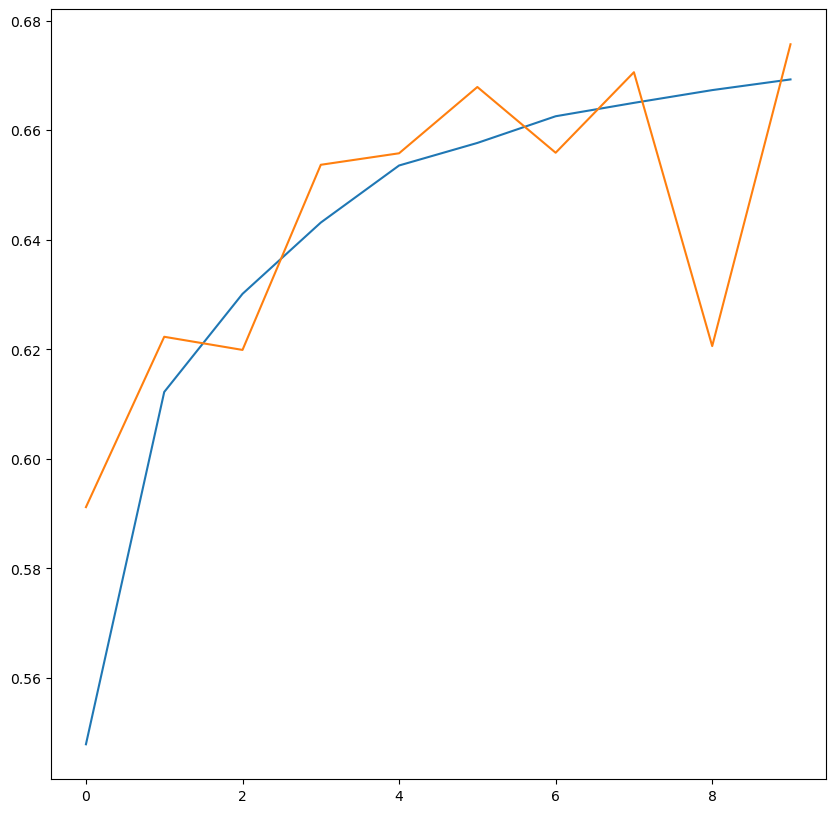

In [14]:
plt.figure(figsize=(10,10))
plt.plot(range(epochs), torch.Tensor(train_acc).cpu())
plt.plot(range(epochs), torch.Tensor(test_acc).cpu())
plt.show()

In [15]:
torch.save(model.state_dict(), 'model_weights.pth')

In [17]:
data_train_np = np.asarray(data_train)
data_test_np = np.asarray(data_test)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 3 dimensions. The detected shape was (810921, 4, 2) + inhomogeneous part.

In [ ]:
data_train_np.shape